# Notebook - Fractopo – KB11 Fracture Network Analysis

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Cell contents only required for development env runs
from importlib.util import find_spec

if find_spec("fractopo") is None:
    import sys

    sys.path.append("..")

In [3]:
from fractopo import Network
import matplotlib.pyplot as plt
import geopandas as gpd
from ast import literal_eval
from pprint import pprint

plt.close()

## Data

Trace and target area data required. The paths can be urls to GeoJSON or local file paths to spatial filetypes (e.g. shapefile, geopackage). The name is used in plot labels and titles.

In [4]:
trace_data = ""
area_data = ""
name = ""
circular_target_area = ""

The defaults in the next cell are only applied if no parameters are given to the above cell.

In [5]:
if len(trace_data) == 0:
    # Set defaults
    # Trace and target area data available on GitHub
    trace_data = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_traces.geojson"
    area_data = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_area.geojson"
    # Name the dataset
    name = "KB11"
    circular_target_area = False

In [6]:
# convert circular_target_area to boolean if it is a string (e.g. from papermill invocation)
# will default to false if cannot be converted
if isinstance(circular_target_area, str):
    if len(circular_target_area) > 0:
        converted = literal_eval(circular_target_area)
        if not isinstance(converted, bool):
            converted = False
    else:
        converted = False
circular_target_area = False

In [7]:
# Use geopandas to load data from urls
traces = gpd.read_file(trace_data)
area = gpd.read_file(area_data)

28890-WARNING-Skipping field VALIDATION_ERRORS: invalid type 5


In [8]:
area.total_bounds

array([ 465993.9355, 6691562.9084,  466048.6197, 6691606.3108])

In [9]:
def focus_plot_to_bounds(ax, total_bounds):
    xmin, ymin, xmax, ymax = total_bounds
    extend_x = (xmax - xmin) * 0.05
    extend_y = (ymax - ymin) * 0.05
    ax.set_xlim(xmin - extend_x, xmax + extend_x)
    ax.set_ylim(ymin - extend_y, ymax + extend_y)
    return ax

## Visualizing trace map data

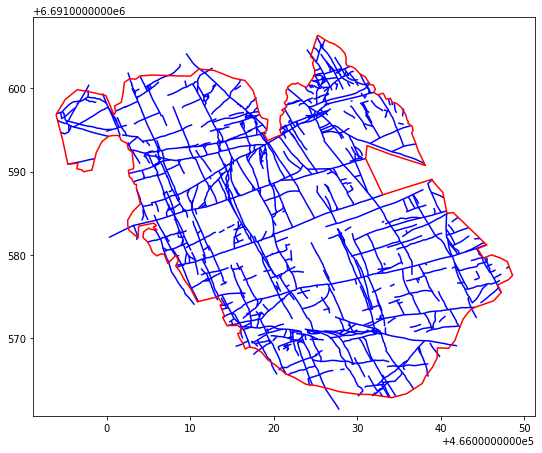

In [10]:
fix, ax = plt.subplots(figsize=(9, 9))
traces.plot(ax=ax, color="blue")
area.boundary.plot(ax=ax, color="red")
ax = focus_plot_to_bounds(ax, area.total_bounds)

## Create Network

In [11]:
# Create Network and automatically determine branches and nodes
network = Network(
    traces,
    area,
    name=name,
    determine_branches_nodes=True,
    snap_threshold=0.001,
    truncate_traces=True,
    circular_target_area=circular_target_area,
)

## Visualizing branches and nodes

In [12]:
from fractopo.general import CC_branch, CI_branch, II_branch, X_node, Y_node, I_node


# Function to determine color for each branch and node type
def assign_colors(feature_type: str):
    if feature_type in (CC_branch, X_node):
        return "green"
    if feature_type in (CI_branch, Y_node):
        return "blue"
    if feature_type in (II_branch, I_node):
        return "black"
    return "red"

| Branch or Node Type | Color |
|---------------------|-------|
| C - C, X            | Green |
| C - I, Y            | Blue  |
| I - I, I            | Black |
| Other               | Red   |

### Branches

<AxesSubplot:>

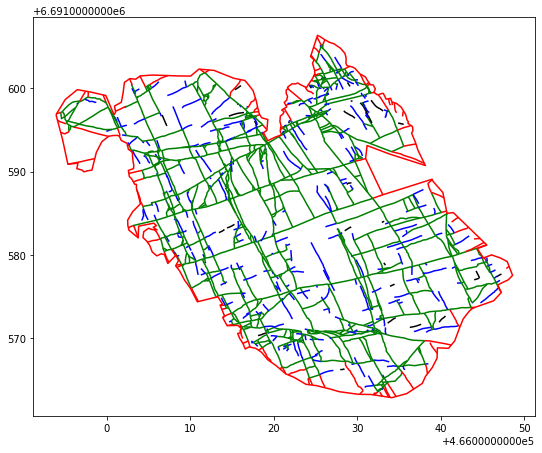

In [13]:
fix, ax = plt.subplots(figsize=(9, 9))
network.branch_gdf.plot(
    colors=[assign_colors(bt) for bt in network.branch_types], ax=ax
)
area.boundary.plot(ax=ax, color="red")

### Nodes

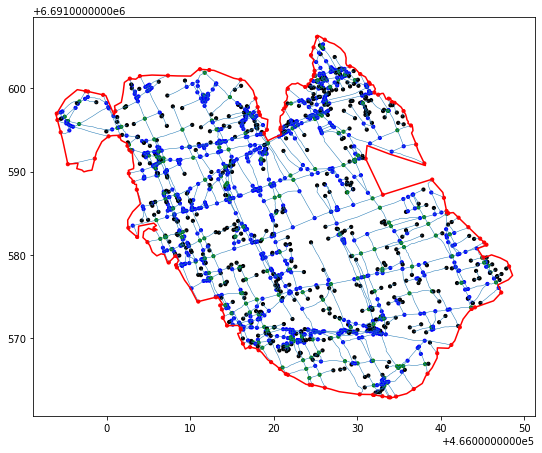

In [14]:
fix, ax = plt.subplots(figsize=(9, 9))
# Traces
network.trace_gdf.plot(ax=ax, linewidth=0.5)
# Nodes
network.node_gdf.plot(
    c=[assign_colors(bt) for bt in network.node_types], ax=ax, markersize=10
)
area.boundary.plot(ax=ax, color="red")
ax = focus_plot_to_bounds(ax, area.total_bounds)

## Rose plots

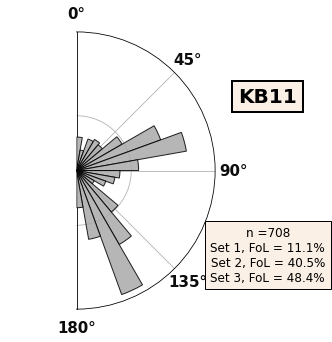

In [15]:
# Plot azimuth rose plot of fracture traces
azimuth_bin_dict, fig, ax = network.plot_trace_azimuth()

## Length distributions

### Trace length distribution

In [16]:
# Fit for traces
fit_traces = network.trace_lengths_powerlaw_fit()

Calculating best minimal value for power law fit


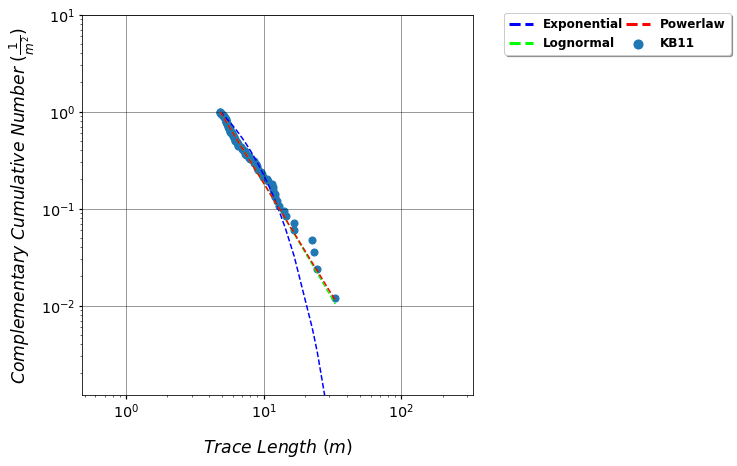

In [17]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture traces
fit, fig, ax = network.plot_trace_lengths()

In [18]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit_traces.xmin}")
print(f"Powerlaw exponent: {fit_traces.alpha - 1}")
print(
    f"Proportion of data cut off by cut off: {network.trace_lengths_cut_off_proportion()}"
)
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit_traces.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 4.815579557192599
Powerlaw exponent: 2.323399316187791
Proportion of data cut off by cut off: 0.8813559322033898
Compare powerlaw fit to lognormal: R, p = (-0.009629061290125973, 0.9205510020886896)


### Branch length distribution

In [19]:
# Fit for branches
fit_branches = network.branch_lengths_powerlaw_fit()

Calculating best minimal value for power law fit


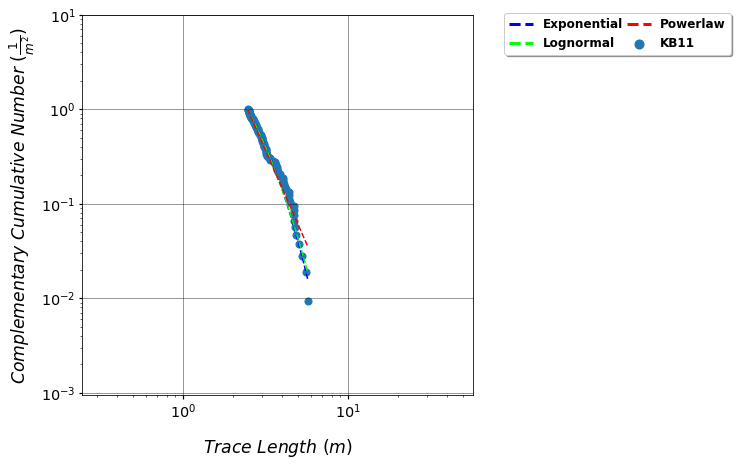

In [20]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture branches
fit, fig, ax = network.plot_branch_lengths()

In [21]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit_branches.xmin}")
print(f"Powerlaw exponent: {fit_branches.alpha - 1}")
print(
    f"Proportion of data cut off by cut off: {network.branch_lengths_cut_off_proportion()}"
)
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit_branches.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 2.4602426465576075
Powerlaw exponent: 3.979095845241388
Proportion of data cut off by cut off: 0.9488416988416989
Compare powerlaw fit to lognormal: R, p = (-1.5646795886550333, 0.2118812831213549)


## Crosscutting and abutting relationships

In [22]:
# Sets are defaults
print(f"Azimuth set names: {network.azimuth_set_names}")
print(f"Azimuth set ranges: {network.azimuth_set_ranges}")

Azimuth set names: ('1', '2', '3')
Azimuth set ranges: ((0, 60), (60, 120), (120, 180))


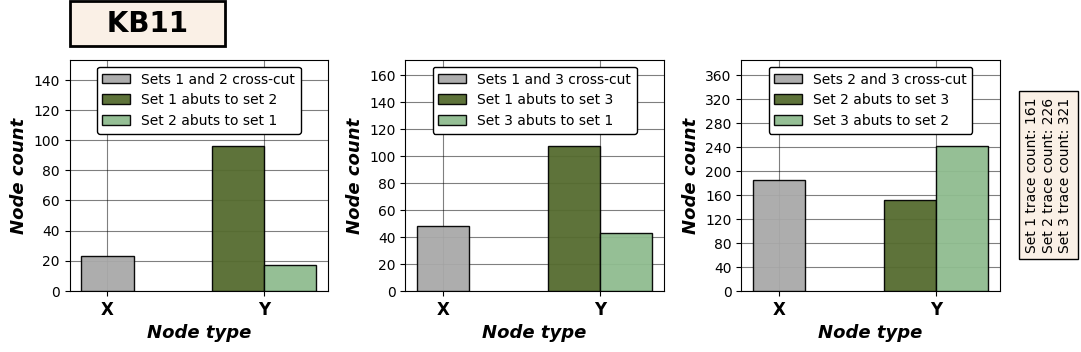

In [23]:
# Plot crosscutting and abutting relationships between azimuth sets
figs, fig_axes = network.plot_azimuth_crosscut_abutting_relationships()

## Node and branch proportions

In [24]:
network.node_counts

{'X': 270, 'Y': 824, 'I': 478, 'E': 114}

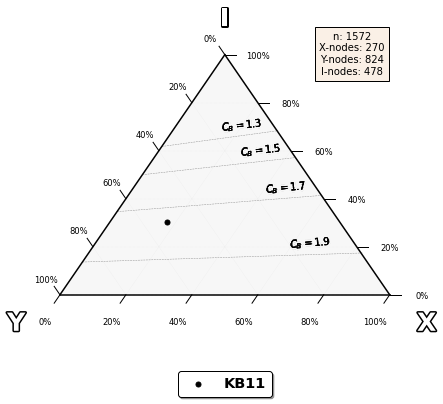

In [25]:
# Plot ternary XYI-node proportion plot
fig, ax, tax = network.plot_xyi()

In [26]:
network.branch_counts

{'C - C': 1521,
 'C - I': 410,
 'I - I': 28,
 'C - E': 100,
 'I - E': 12,
 'E - E': 1}

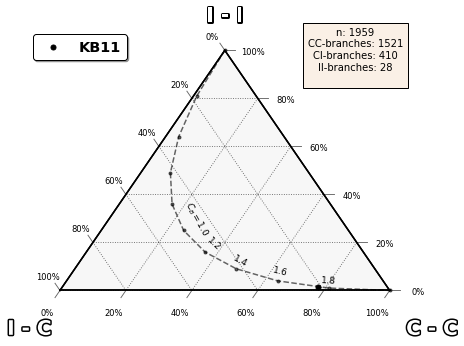

In [27]:
# Plot ternary branch (C-C, C-I, I-I) proportion plot
fig, ax, tax = network.plot_branch()

# General topological and geometric parameters

In [28]:
network.parameters

{'Fracture Intensity B21': 1.2633728710290455,
 'Fracture Intensity P21': 1.2633728710290455,
 'Trace Mean Length': 2.208940309504849,
 'Dimensionless Intensity P22': 2.7907152607509293,
 'Area': 1237.9003657531266,
 'Number of Traces': 651.0,
 'Branch Mean Length': 0.7761437911312323,
 'Areal Frequency B20': 1.627756203766927,
 'Areal Frequency P20': 0.5258904658323919,
 'Dimensionless Intensity B22': 0.9805590097328328,
 'Connections per Trace': 3.3609831029185866,
 'Connections per Branch': 1.7627791563275435,
 'Fracture Intensity (Mauldon)': 1.4357438039436288,
 'Fracture Density (Mauldon)': 0.5258904658323919,
 'Trace Mean Length (Mauldon)': 2.7301194777720483,
 'Connection Frequency': 0.8837544848243267,
 'Number of Branches': 2015.0}

# Contour grids for target area

In [29]:
sampled_grid = network.contour_grid(
    cell_width=1.5,
)

In [30]:
pprint(sampled_grid.columns.to_list())

['geometry',
 'Number of Traces',
 'Number of Branches',
 'Trace Mean Length',
 'Branch Mean Length',
 'Connections per Branch',
 'Areal Frequency B20',
 'Fracture Intensity B21',
 'Dimensionless Intensity B22',
 'Connections per Trace',
 'Areal Frequency P20',
 'Fracture Intensity P21',
 'Dimensionless Intensity P22',
 'Trace Mean Length (Mauldon)',
 'Fracture Intensity (Mauldon)',
 'Fracture Density (Mauldon)',
 'Connection Frequency',
 'Area']


(<Figure size 864x864 with 2 Axes>, <AxesSubplot:title={'center':'KB11'}>)

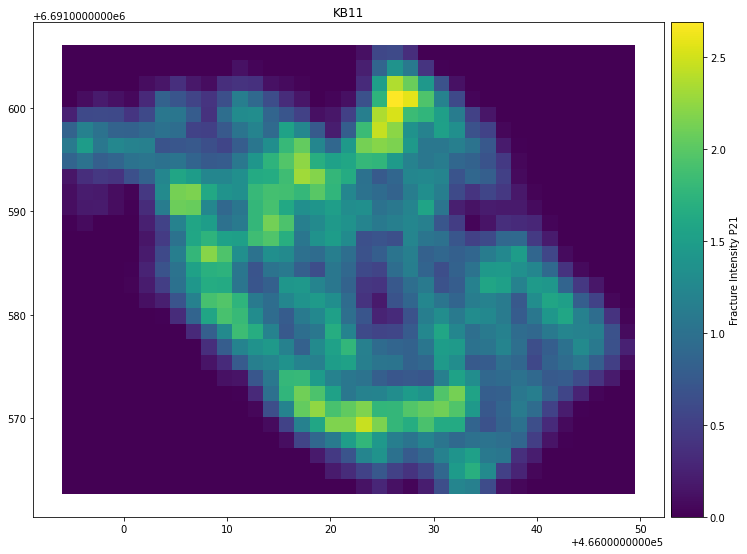

In [31]:
network.plot_contour(parameter="Fracture Intensity P21", sampled_grid=sampled_grid)

(<Figure size 864x864 with 2 Axes>, <AxesSubplot:title={'center':'KB11'}>)

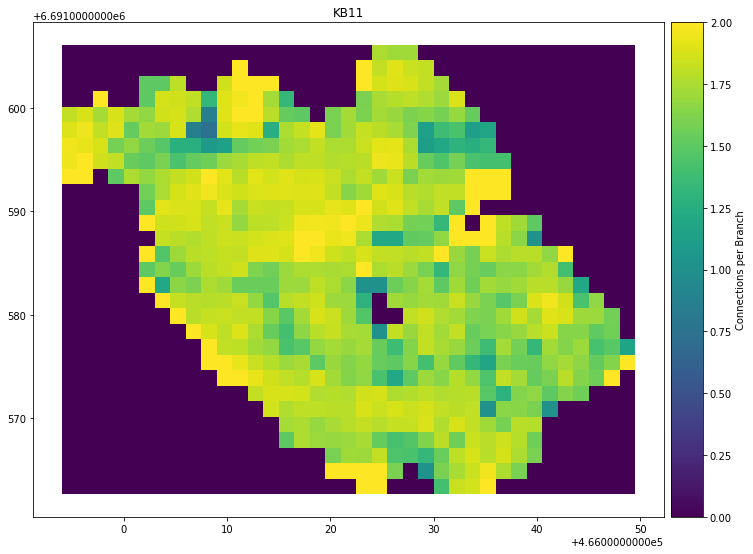

In [32]:
network.plot_contour(parameter="Connections per Branch", sampled_grid=sampled_grid)